In [1]:
import torch
import clip

from PIL import Image
import os

device = "cuda" if torch.cuda.is_available() else "cpu"


def get_image_embedding(image):
    preprocessed_image = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(preprocessed_image)
        return image_features


def get_images_from_folder(folder_path):
    images = []

    for filename in os.listdir(folder_path):
        # Check if the file is an image file
        if filename.endswith(".jpg") or filename.endswith(".png") or filename.endswith(".jpeg"):
            # Open the image using PIL
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path)
            # Append the image to the list
            images.append(get_image_embedding(image))

    return images




In [2]:
model, preprocess = clip.load("ViT-B/32", device=device)

In [ ]:
import torch
import torch.nn.functional as F

In [33]:
crown_image_embeddings = get_images_from_folder("Dataset/GoldRatings-10a/crown_royalty__smoke_fire__/crown")
royalty_image_embeddings = get_images_from_folder("Dataset/GoldRatings-10a/crown_royalty__smoke_fire__/royalty")
fire_image_embeddings = get_images_from_folder("Dataset/GoldRatings-10a/crown_royalty__smoke_fire__/fire")
smoke_image_embeddings = get_images_from_folder("Dataset/GoldRatings-10a/crown_royalty__smoke_fire__/smoke")


crown_tensor = torch.squeeze(torch.stack(crown_image_embeddings, dim=0), dim=1)
royalty_tensor = torch.squeeze(torch.stack(royalty_image_embeddings, dim=0), dim=1)
fire_tensor = torch.squeeze(torch.stack(fire_image_embeddings, dim=0), dim=1)
smoke_tensor = torch.squeeze(torch.stack(smoke_image_embeddings, dim=0), dim=1)

print(crown_tensor.size())
print(royalty_tensor.size())
print(fire_tensor.size())
print(smoke_tensor.size())

# Average of embeddings
crown_average_embedding = torch.mean(crown_tensor, dim=0)
royalty_average_embedding = torch.mean(royalty_tensor, dim=0)
fire_average_embedding = torch.mean(fire_tensor, dim=0)
smoke_average_embedding = torch.mean(smoke_tensor, dim=0)

print(crown_average_embedding.size())
# print(crown_average_embedding)

print(royalty_average_embedding.size())
# print(royalty_average_embedding)

print(fire_average_embedding.size())
# print(fire_average_embedding)

print(smoke_average_embedding.size())
# print(smoke_average_embedding)

diff1 = crown_average_embedding-royalty_average_embedding
diff2 = smoke_average_embedding-fire_average_embedding

cos_sim = F.cosine_similarity(diff1, diff2, dim=0)

print(cos_sim)

torch.rad2deg(torch.acos(cos_sim))

torch.Size([9, 512])
torch.Size([9, 512])
torch.Size([9, 512])
torch.Size([9, 512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
tensor(-0.1692)


tensor(99.7405)

In [35]:
crown_image_embeddings = get_images_from_folder("Dataset/GoldRatings-10b/laugh_happiness__nod_agreement__/agreement")
royalty_image_embeddings = get_images_from_folder("Dataset/GoldRatings-10b/laugh_happiness__nod_agreement__/happiness")
fire_image_embeddings = get_images_from_folder("Dataset/GoldRatings-10b/laugh_happiness__nod_agreement__/laugh")
smoke_image_embeddings = get_images_from_folder("Dataset/GoldRatings-10b/laugh_happiness__nod_agreement__/nod")


crown_tensor = torch.squeeze(torch.stack(crown_image_embeddings, dim=0), dim=1)
royalty_tensor = torch.squeeze(torch.stack(royalty_image_embeddings, dim=0), dim=1)
fire_tensor = torch.squeeze(torch.stack(fire_image_embeddings, dim=0), dim=1)
smoke_tensor = torch.squeeze(torch.stack(smoke_image_embeddings, dim=0), dim=1)

print(crown_tensor.size())
print(royalty_tensor.size())
print(fire_tensor.size())
print(smoke_tensor.size())

# Average of embeddings
crown_average_embedding = torch.mean(crown_tensor, dim=0)
royalty_average_embedding = torch.mean(royalty_tensor, dim=0)
fire_average_embedding = torch.mean(fire_tensor, dim=0)
smoke_average_embedding = torch.mean(smoke_tensor, dim=0)

print(crown_average_embedding.size())
# print(crown_average_embedding)

print(royalty_average_embedding.size())
# print(royalty_average_embedding)

print(fire_average_embedding.size())
# print(fire_average_embedding)

print(smoke_average_embedding.size())
# print(smoke_average_embedding)

diff1 = crown_average_embedding-royalty_average_embedding
diff2 = smoke_average_embedding-fire_average_embedding

cos_sim = F.cosine_similarity(diff1, diff2, dim=0)

print(cos_sim)

angle_in_degrees = torch.rad2deg(torch.acos(cos_sim))
print("Angle : Averaging ", angle_in_degrees)

torch.Size([9, 512])
torch.Size([9, 512])
torch.Size([9, 512])
torch.Size([9, 512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
tensor(0.3308)


tensor(70.6837)

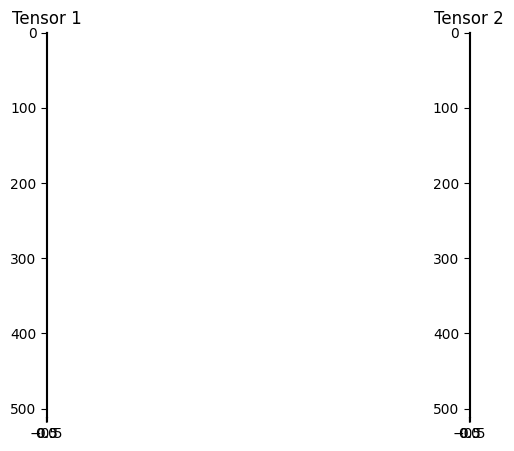

In [36]:
import torch
import matplotlib.pyplot as plt

# Assuming you have two tensors tensor1 and tensor2
# Convert tensors to NumPy arrays
tensor1_np = diff1.cpu().numpy()
tensor2_np = diff2.cpu().numpy()

# Plot the tensors
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(tensor1_np.reshape(512,1))
plt.title('Tensor 1')

plt.subplot(1, 2, 2)
plt.imshow(tensor2_np.reshape(512,1))
plt.title('Tensor 2')

plt.show()
